In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import tarfile
import igraph as ig
%matplotlib inline

from planar import create_proximity_graph
from auxiliary import get_base_network_name, load_delta_data
from auxiliary import powerlaw, getLinearReg
from fractal import get_box_count, get_cluster_densities
import mpl_settings_v3
from mpl_settings_v3 import *
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from cycler import cycler

net_type = 'DT'
param = 'param'

net_dir = os.path.join('../networks', net_type)
fig_dir = '../draft/figs'

attack_dict = {
    'Ran': r'$\mathrm{Rnd}$', 'Deg': r'$\mathrm{ID}$', 'DegU': r'$\mathrm{RD}$',
    'Btw': r'$\mathrm{IB}$', 'BtwU': r'$\mathrm{RB}$', 
    'Eigenvector': r'$\mathrm{IE}$', 'EigenvectorU': r'$\mathrm{RE}$',
    'CI': r'$\mathrm{ICI}$', 'CIU': r'$\mathrm{RCI}$', 'CIU2': r'$\mathrm{RCI2}$',
}

for i in range(2, 100):
    attack_dict['BtwU_cutoff{}'.format(i)] = r'$\mathrm{RB}$' + r'${{{}}}$'.format(i)

measures_dict = {
    'Nsec': r'$N_2$',
    'meanS': r'$\langle s \rangle$'
}

letters = [r'$\mathrm{(a)}$', r'$\mathrm{(b)}$', r'$\mathrm{(c)}$', r'$\mathrm{(d)}$',
           r'$\mathrm{(e)}$', r'$\mathrm{(f)}$', r'$\mathrm{(g)}$', r'$\mathrm{(h)}$']

attack_colors = {
    'B': '#27647b', 'D': '#ca3542', 'R': '#57575f', 'E': '#50C878',
    'C': '#80471C', # Brown peanut
    'B3': '#6F2DA8', # Purple
    'B4': '#F05E23' # Orange salamander
}


Bad key "text.kerning_factor" on line 4 in
/home/nahuel/anaconda3/envs/networks3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
def load_delta(net_type, size, param, attack, nseeds=None):
    dir_name = os.path.join('../networks', net_type)
    base_net_name, base_net_name_size = get_base_network_name(net_type, size, param)
    net_dir_name = os.path.join(dir_name, base_net_name,
            base_net_name_size
    )
    if nseeds:
        delta_file_name = os.path.join(net_dir_name,
            'Delta_values_' + attack + '_nSeeds{:d}.txt'.format(nseeds)
        )
    else:
        files = [file for file in os.listdir(net_dir_name) if 'Delta' in file]
        files = [file for file in files if attack + '_nSeeds' in file]
        #print(files)
        idx = np.argmax([int(file.split('nSeeds')[1].split('.')[0]) for file in files])
        file_name = files[idx]
        delta_file_name = os.path.join(net_dir_name, file_name)
    delta_values = np.loadtxt(delta_file_name)
    return delta_values

def average_delta(net_type, param, attack, N_values, nseeds):
    mean_pos_values = []
    std_pos_values = []
    mean_delta_values = []
    std_delta_values = []
    for N in N_values:
        try:
            delta_values = load_delta(net_type, N, param, attack, nseeds)
        except:
            delta_values = load_delta(net_type, N, param, attack, nseeds//10)
        pos, delta = delta_values.mean(axis=0)
        std_pos, std_delta = delta_values.std(axis=0)
        mean_pos_values.append(pos)
        std_pos_values.append(std_pos)
        mean_delta_values.append(delta)
        std_delta_values.append(std_delta)
    return mean_pos_values, std_pos_values, mean_delta_values, std_delta_values

def load_dataframe(net_type, size, param, attack, nseeds=None):
    dir_name = os.path.join('../networks', net_type)
    base_net_name, base_net_name_size = get_base_network_name(net_type, size, param)
    net_dir_name = os.path.join(dir_name, base_net_name,
            base_net_name_size
    )
    if nseeds:
        full_file_name = os.path.join(net_dir_name,
            attack + '_nSeeds{:d}_cpp.csv'.format(nseeds)
        )
    else:
        files = [file for file in os.listdir(net_dir_name) if 'cpp' in file]
        files = [file for file in files if attack + '_nSeeds' in file]
        #print(files)
        idx = np.argmax([int(file.split('nSeeds')[1].split('_')[0]) for file in files])
        file_name = files[idx]
        full_file_name = os.path.join(net_dir_name, file_name)

    df = pd.read_csv(full_file_name, index_col=0)
    return df

### **Fig. 1 from Fan (2020)**

In [93]:
if False:
    net_type = 'ER'
    param = '3.50'
    attack = 'Ran'
else:
    net_type = 'DT'
    param = 'param'
    attack = 'BtwU'
    
nseeds_per_size = {
    128: 10000,
    256: 10000,
    512: 10000,
    1024: 10000,
    2048: 10000,
    4096: 10000,
    8192: 1000,
    16384: 100
}
#sizes = [128, 256, 512, 1024]#, 2048, 4096, 8192]#, 16384]
sizes = [512, 1024, 2048, 4096, 8192, 16384]
all_mean_values = []
all_std_values = []
fluctuations = {}
for i, N in enumerate(sizes):
    print(N)
    nseeds = nseeds_per_size[N]
    delta_values = load_delta(net_type, N, param, attack)
    delta_values[:,2] = delta_values[:,2]*N
    mean_values = delta_values.mean(axis=0)
    
    #std_values = np.sqrt(((delta_values**2).mean(axis=0) - delta_values.mean(axis=0)**2))
    std_values = delta_values.std(axis=0)
    
    all_mean_values.append(mean_values)
    all_std_values.append(std_values)
    
    fluctuations[N] = delta_values - mean_values
    
all_mean_values = np.array(all_mean_values)
all_std_values = np.array(all_std_values)
print(all_mean_values)
print(all_std_values)

512
1024
2048
4096
8192
16384
[[5.92548828e-02 3.90294336e-01 4.74001700e+02]
 [4.77549805e-02 3.96196289e-01 9.59739400e+02]
 [3.87534668e-02 4.02631348e-01 1.94038200e+03]
 [3.18780065e-02 4.07948826e-01 3.91346699e+03]
 [2.63262447e-02 4.15679742e-01 7.90654244e+03]
 [2.18761089e-02 4.14305494e-01 1.58822725e+04]]
[[1.12030266e-02 5.99590746e-02 3.39894292e+01]
 [8.48407009e-03 5.89220343e-02 6.68960798e+01]
 [6.60435612e-03 5.73958031e-02 1.28085291e+02]
 [5.16236344e-03 5.58513918e-02 2.44515774e+02]
 [3.91051912e-03 5.14709204e-02 4.04450830e+02]
 [3.25977253e-03 5.44007064e-02 8.03288366e+02]]


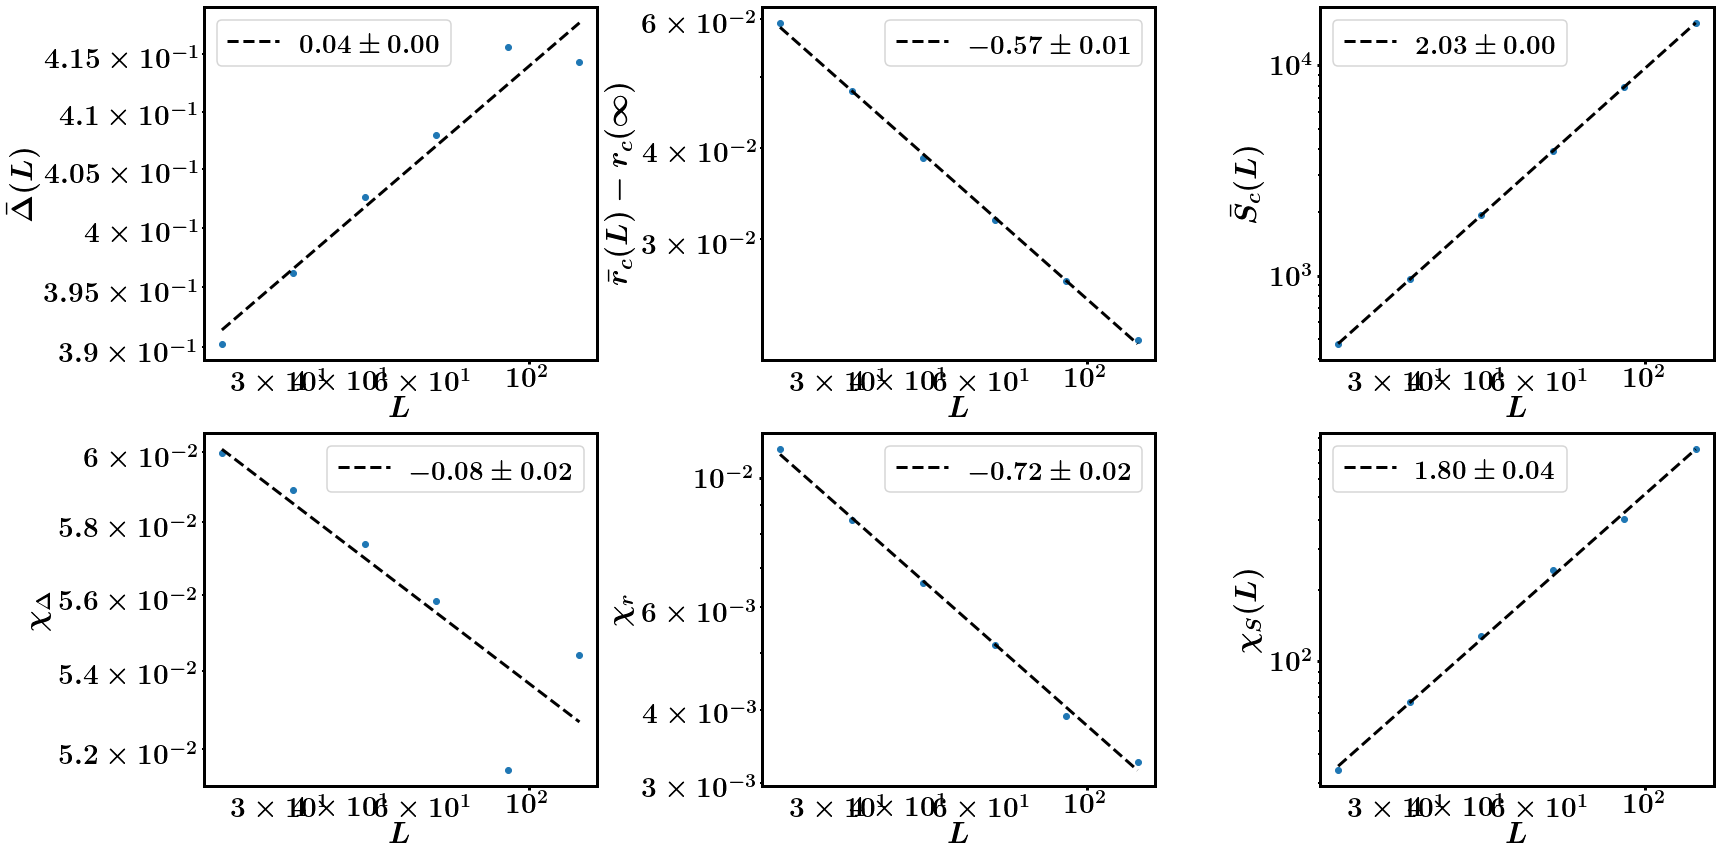

In [94]:
if net_type == 'Lattice':
    X = np.sqrt(sizes)
    str_size = 'L'
else:
    X = np.sqrt(sizes)
    str_size = 'L'
    

ncols = 3
nrows = 2
fig, axes = plt.subplots(figsize=(8*ncols, 6*nrows), ncols=ncols, nrows=nrows)

for ax in axes.flatten():
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r'${{{}}}$'.format(str_size))
    
ax = axes[0][0]
ax.set_ylabel(r'$\bar{\Delta}(L)$')
Y = all_mean_values[:,1]
Y_pred, slope, y_err = getLinearReg(X, Y)
ax.plot(X, Y, 'o')
ax.plot(X, Y_pred, '--', color='k', label=r'${{{:.2f}}}\pm{{{:.2f}}}$'.format(slope, y_err))

ax = axes[1,0]
ax.set_ylabel(r'$\chi_{\Delta}$')
Y = all_std_values[:,1]
Y_pred, slope, y_err = getLinearReg(X, Y)
ax.plot(X, Y, 'o')
ax.plot(X, Y_pred, '--', color='k', label=r'${{{:.2f}}}\pm{{{:.2f}}}$'.format(slope, y_err))

ax = axes[0,1]
ax.set_ylabel(r'$\bar{r}_c(L) - r_c(\infty)$')
rc = 0
if attack == 'Ran' and net_type == 'ER':
    rc = 1/3.5
Y = all_mean_values[:,0] - rc
Y_pred, slope, y_err = getLinearReg(X, Y)
ax.plot(X, Y, 'o')
ax.plot(X, Y_pred, '--', color='k', label=r'${{{:.2f}}}\pm{{{:.2f}}}$'.format(slope, y_err))

ax = axes[1,1]
ax.set_ylabel(r'$\chi_{r}$')
Y = all_std_values[:,0]
Y_pred, slope, y_err = getLinearReg(X, Y)
ax.plot(X, Y, 'o')
ax.plot(X, Y_pred, '--', color='k', label=r'${{{:.2f}}}\pm{{{:.2f}}}$'.format(slope, y_err))


ax = axes[0,2]
ax.set_ylabel(r'$\bar{S}_c(L)$')
Y = all_mean_values[:,2]
Y_pred, slope, y_err = getLinearReg(X, Y)
ax.plot(X, Y, 'o')
ax.plot(X, Y_pred, '--', color='k', label=r'${{{:.2f}}}\pm{{{:.2f}}}$'.format(slope, y_err))


ax = axes[1,2]
ax.set_ylabel(r'$\chi_{S}(L)$')
Y = all_std_values[:,2]
Y_pred, slope, y_err = getLinearReg(X, Y)
ax.plot(X, Y, 'o')
ax.plot(X, Y_pred, '--', color='k', label=r'${{{:.2f}}}\pm{{{:.2f}}}$'.format(slope, y_err))

for ax in axes.flatten():
    ax.legend()

plt.tight_layout()
fig_name = os.path.join(fig_dir, 'Fan2020_fig1_{}_{}'.format(net_type, attack))
plt.savefig(fig_name + '.png')
plt.savefig(fig_name + '.pdf')
plt.show()

### **Fig 2, Fan (2020)**

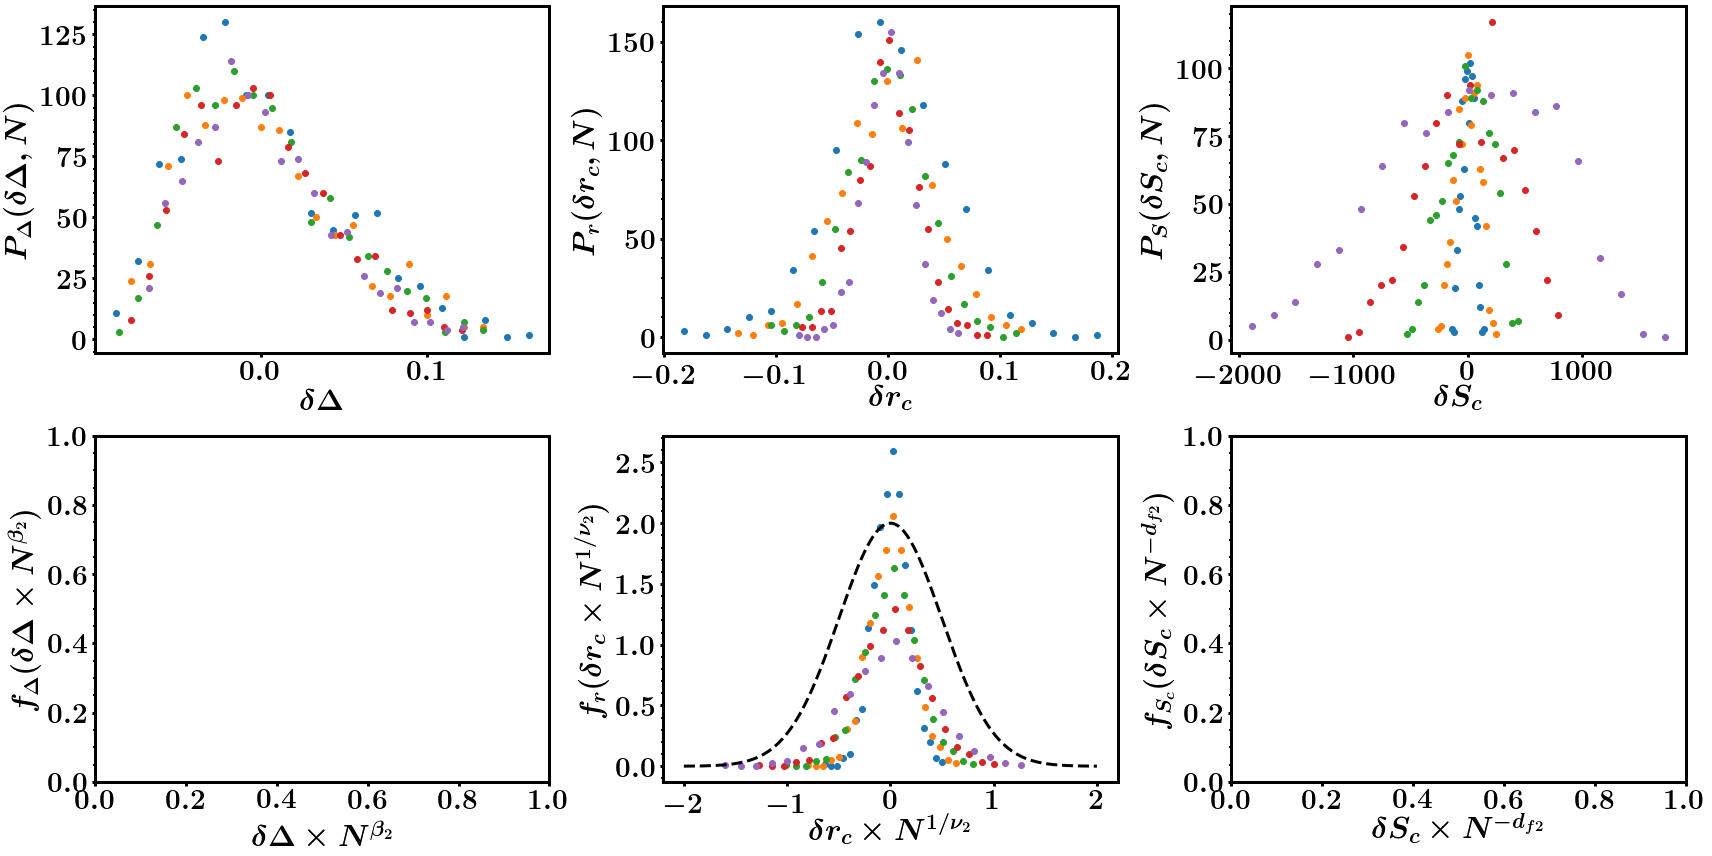

In [112]:
def f_r(z, zc, omega):
    return (1/omega) * np.exp(-(z-zc)**2/(2*omega**2))

if net_type == 'ER' and attack == 'Ran':
    rc = 1/3.5
    nu_2 = 3
    beta_2 = 1/3
    d_f2 = 2/3

bins = 20
ncols = 3
nrows = 2
fig, axes = plt.subplots(figsize=(8*ncols,6*nrows), ncols=ncols, nrows=nrows)

axes[0][0].set_xlabel(r'$\delta \Delta$')
axes[0][0].set_ylabel(r'$P_{\Delta}(\delta \Delta, N)$')
axes[1][0].set_xlabel(r'$\delta \Delta\times N^{\beta_2}$')
axes[1][0].set_ylabel(r'$f_{\Delta}(\delta \Delta \times N^{\beta_2})$')

axes[0][1].set_xlabel(r'$\delta r_c$')
axes[0][1].set_ylabel(r'$P_{r}(\delta r_c, N)$')
axes[1][1].set_xlabel(r'$\delta r_c\times N^{1/\nu_2}$')
axes[1][1].set_ylabel(r'$f_{r}(\delta r_c \times N^{1/\nu_2})$')

axes[0][2].set_xlabel(r'$\delta S_c$')
axes[0][2].set_ylabel(r'$P_{S}(\delta S_c, N)$')
axes[1][2].set_xlabel(r'$\delta S_c\times N^{-d_{f2}}$')
axes[1][2].set_ylabel(r'$f_{S_c}(\delta S_c \times N^{-d_{f2}})$')

index = [1, 0, 2]

for i, ax in enumerate(axes[0]):
    for size in sizes:
        freq, bin_edges = np.histogram(fluctuations[size][:,index[i]], bins=bins)
        bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
        ax.plot(bin_centers, freq, 'o')
        

ax = axes[1][1]
for size in sizes:
    freq, bin_edges = np.histogram(
        fluctuations[N][:,0] * size**(1/nu_2), bins=bins, density=True
    )
    bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
    #ax.plot(bin_centers * size**(1/nu_2), freq, 'o')
    ax.plot(bin_centers, freq, 'o')

        
ax = axes[1][1]
X = np.linspace(-2, 2, 10000)
#zc = rc * size**(1/nu)
omega = 0.5
F = lambda x: f_r(x, rc, omega)
ax.plot(X, F(X), '--', color='k')
        
plt.tight_layout()
fig_name = os.path.join(fig_dir, 'Fan2020_fig2_{}_{}'.format(net_type, attack))
plt.savefig(fig_name + '.png')
plt.savefig(fig_name + '.pdf')
plt.show()

In [3]:
load_delta('DT', 16384, 'param', 'BtwU_cutoff68')

['Delta_values_BtwU_cutoff4_nSeeds100.txt', 'Delta_values_BtwU_nSeeds100.txt', 'Delta_values_BtwU_cutoff48_nSeeds100.txt', 'Delta_values_BtwU_cutoff16_nSeeds100.txt', 'Delta_values_BtwU_cutoff32_nSeeds100.txt', 'Delta_values_BtwU_cutoff27_nSeeds100.txt', 'Delta_values_BtwU_cutoff3_nSeeds100.txt', 'Delta_values_BtwU_cutoff72_nSeeds100.txt', 'Delta_values_BtwU_cutoff2_nSeeds100.txt', 'Delta_values_BtwU_nSeeds10000.txt', 'Delta_values_BtwU_cutoff45_nSeeds100.txt', 'Delta_values_BtwU_cutoff8_nSeeds100.txt', 'Delta_values_BtwU_cutoff64_nSeeds100.txt', 'Delta_values_BtwU_cutoff24_nSeeds100.txt']


ValueError: max() arg is an empty sequence

In [89]:
sizes = [128, 256, 512, 1024, 2048, 4096, 8192, 16384]
l_values = np.arange(2, 100)
attacks = ['BtwU'] + ['BtwU_cutoff{}'.format(l) for l in l_values]
rc_values = {}
rc_values_std = {}
for size in sizes:
    print(size)
    #nseeds = nseeds_per_size[size]
    rc_values[size] = []
    rc_values_std[size] = []
    for attack in attacks:
        #print(attack)
        try:
            delta_values = load_delta(net_type, size, param, attack)
            rc = delta_values[:,0].mean(axis=0)
            rc_std = delta_values[:,0].std(axis=0) / np.sqrt(delta_values.shape[0]-1)
            rc_values[size].append(rc)
            rc_values_std[size].append(rc_std)
        except:
            rc_values[size].append(np.NaN)
            rc_values_std[size].append(np.NaN)
    rc_values[size] = np.array(rc_values[size])
    rc_values_std[size] = np.array(rc_values_std[size])

#rc_values    

128
256
512
1024


/home/nahuel/anaconda3/envs/networks3/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: loadtxt: Empty input file: "../networks/DT/DT_param/DT_param_N1024/Delta_values_BtwU_cutoff31_nSeeds1000.txt"
/home/nahuel/anaconda3/envs/networks3/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: loadtxt: Empty input file: "../networks/DT/DT_param/DT_param_N1024/Delta_values_BtwU_cutoff32_nSeeds1000.txt"


2048
4096


/home/nahuel/anaconda3/envs/networks3/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: loadtxt: Empty input file: "../networks/DT/DT_param/DT_param_N4096/Delta_values_BtwU_cutoff31_nSeeds100.txt"


8192


/home/nahuel/anaconda3/envs/networks3/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: loadtxt: Empty input file: "../networks/DT/DT_param/DT_param_N8192/Delta_values_BtwU_cutoff17_nSeeds100.txt"
/home/nahuel/anaconda3/envs/networks3/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: loadtxt: Empty input file: "../networks/DT/DT_param/DT_param_N8192/Delta_values_BtwU_cutoff18_nSeeds100.txt"
/home/nahuel/anaconda3/envs/networks3/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: loadtxt: Empty input file: "../networks/DT/DT_param/DT_param_N8192/Delta_values_BtwU_cutoff19_nSeeds100.txt"
/home/nahuel/anaconda3/envs/networks3/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: loadtxt: Empty input file: "../networks/DT/DT_param/DT_param_N8192/Delta_values_BtwU_cutoff21_nSeeds100.txt"
/home/nahuel/anaconda3/envs/networks3/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: loadtxt: Empty input file: "../networks

16384


In [75]:
#print(list(zip(l_values, rc_values[16384][1:])))
arr = np.array(rc_values[2048])
np.where(~np.isnan(arr))[0][1:] + 1

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32])

KeyError: 2048

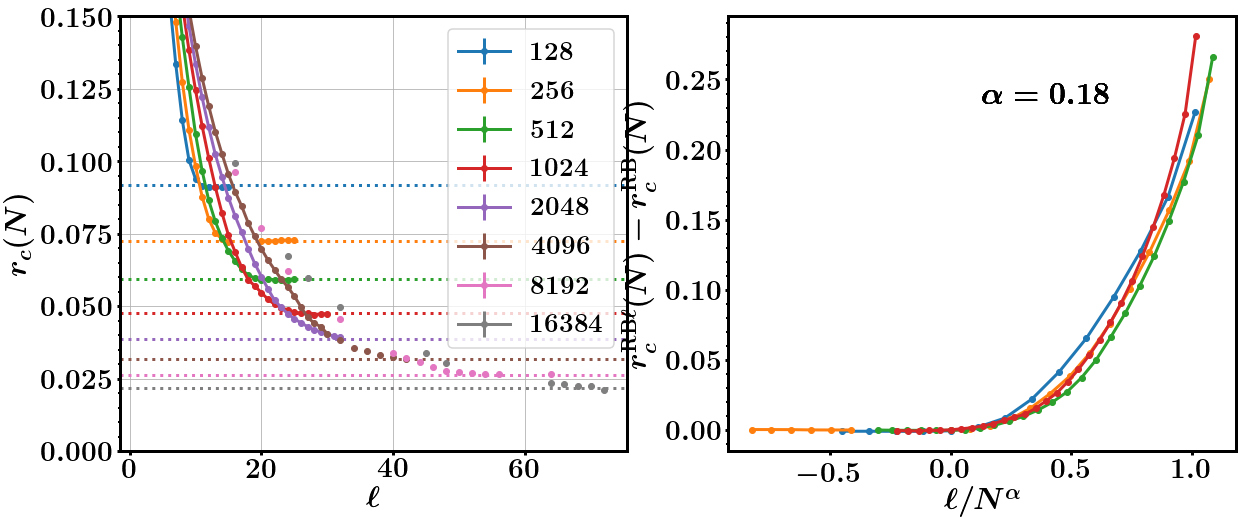

In [90]:
ncols = 2
nrows = 1
fig, axes = plt.subplots(figsize=(10*ncols,8*nrows), ncols=ncols, nrows=nrows)

ax = axes[0]
ax.grid(True)
ax.set_ylim(0, 0.15)
ax.set_xlabel(r'$\ell$')
ax.set_ylabel(r'$r_c(N)$')
for i, size in enumerate(sizes):    
    #ax.plot(l_values, rc_values[size][1:], 'o-', 
    #    color=colors[i], label=r'${{{}}}$'.format(size)
    #)
    ax.errorbar(l_values, rc_values[size][1:], rc_values_std[size][1:], marker='o',# 'o-', 
        color=colors[i], label=r'${{{}}}$'.format(size)
    )
    ax.axhline(rc_values[size][0], linestyle=':', color=colors[i])
ax.legend()

ax = axes[1]
ax.set_xlabel(r'$\ell/N^{\alpha}$')
ax.set_ylabel(r'$r_c^{\mathrm{RB}\ell}(N) - r_c^{\mathrm{RB}}(N)$')
#ax.set_yscale('log')
#ax.set_xscale('log')
for i, size in enumerate(sizes):

    e = 0.18
    ax.text(0.5, 0.8, r'$\alpha={{{:.2f}}}$'.format(e), fontsize=30, transform=ax.transAxes)
    #X = l_values / l_cutoff[size]
    X = (- l_values + l_cutoff[size])/size**0.45
    #X = l_values / size**e
    ax.plot(X, rc_values[size][1:]-rc_values[size][0], 'o-', 
        color=colors[i], label=r'${{{}}}$'.format(size)
    )
    
plt.tight_layout()
fig_name = os.path.join(fig_dir, 'peak_shifting_RBl_rc_{}'.format(net_type))
plt.savefig(fig_name + '.png')
plt.savefig(fig_name + '.pdf')

plt.tight_layout()
plt.show()

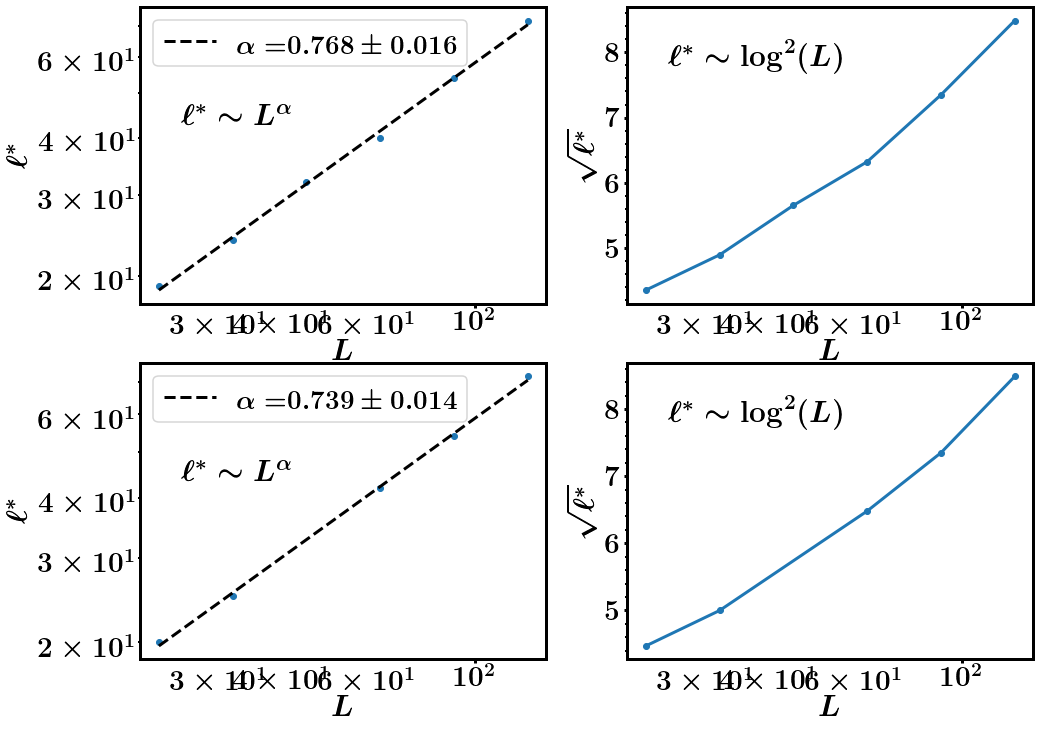

In [106]:
def get_l_cutoff(threshold):
    l_cutoff = {}
    for size in sizes:
        rc_RB = rc_values[size][0]
        for i in range(1, len(rc_values[size])):
            l = i + 1
            rc_RBl = rc_values[size][i]
            if not np.isnan(rc_RBl):
                diff = (rc_RBl - rc_RB) / rc_RB
                if diff < threshold:
                    #print(size, l, diff, sep='\t')
                    l_cutoff[size] = l
                    break
    return l_cutoff

ncols = 2
nrows = 2
fig, axes = plt.subplots(figsize=(8*ncols,6*nrows), ncols=ncols, nrows=nrows)
thresholds = [0.02, 0.005]
for i, th in enumerate(thresholds):
    
    ax = axes[i][0]
    l_cutoff = get_l_cutoff(th)
    X = np.sqrt(list(l_cutoff.keys()))
    Y = np.array(list(l_cutoff.values()))
    ax.set_xlabel(r'$L$')
    ax.set_ylabel(r'$\ell^*$')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.plot(X, Y, 'o')
    Y_pred, slope, y_err = getLinearReg(X, Y)
    label = r'$\alpha = $' + r'${{{:.3f}}}\pm{{{:.3f}}}$'.format(slope, y_err)
    ax.plot(X, Y_pred, '--', color='k', label=label)
    ax.text(0.1, 0.6, r'$\ell^* \sim L^{\alpha}$', fontsize=30, transform=ax.transAxes)
    ax.legend()
    
    ax = axes[i][1]
    l_cutoff = get_l_cutoff(th)
    X = np.sqrt(list(l_cutoff.keys()))
    Y = np.sqrt(list(l_cutoff.values()))
    ax.set_xlabel(r'$L$')
    ax.set_ylabel(r'$\sqrt{\ell^*}$')
    ax.set_xscale('log')
    #ax.set_yscale('log')
    ax.plot(X, Y, 'o-')

    ax.text(0.1, 0.8, r'$\ell^* \sim \log^2 (L)$', fontsize=30, transform=ax.transAxes)

plt.show()

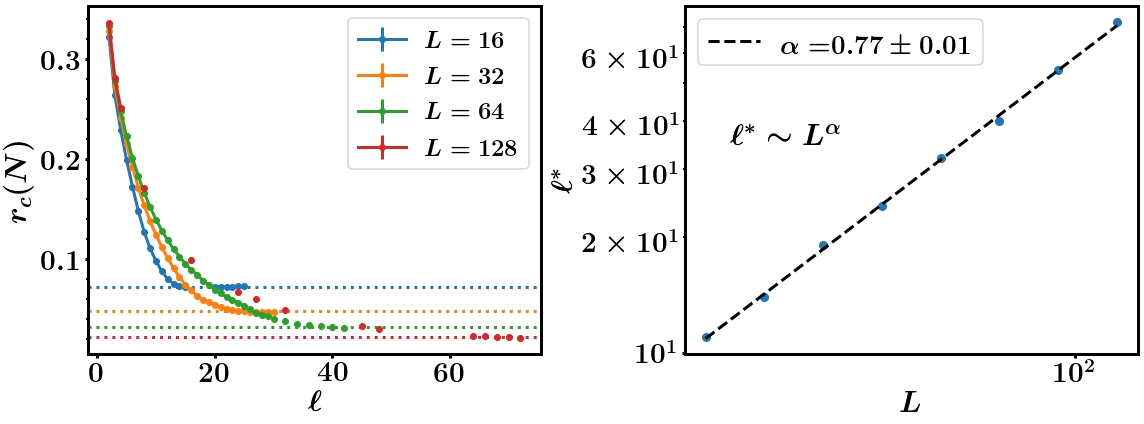

In [84]:
ncols = 2
nrows = 1
fig, axes = plt.subplots(figsize=(8*ncols,6*nrows), ncols=ncols, nrows=nrows)

ax = axes[0]
#ax.grid(True)
#ax.set_ylim(0, 0.15)
ax.set_xlabel(r'$\ell$')
ax.set_ylabel(r'$r_c(N)$')
for i, size in enumerate([256, 1024, 4096, 16384]): 
    ax.errorbar(l_values, rc_values[size][1:], rc_values_std[size][1:], marker='o',# 'o-', 
        color=colors[i], label=r'$L={{{}}}$'.format(int(np.sqrt(size)))
    )
    ax.axhline(rc_values[size][0], linestyle=':', color=colors[i])
ax.legend(fontsize=24)

ax = axes[1]
l_cutoff = get_l_cutoff(0.02)
X = np.sqrt(list(l_cutoff.keys()))
Y = np.array(list(l_cutoff.values()))
ax.set_xlabel(r'$L$')
ax.set_ylabel(r'$\ell^*$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.plot(X, Y, 'o', markersize=8)
Y_pred, slope, y_err = getLinearReg(X, Y)
label = r'$\alpha = $' + r'${{{:.2f}}}\pm{{{:.2f}}}$'.format(slope, y_err)
ax.plot(X, Y_pred, '--', color='k', label=label)
ax.text(0.1, 0.6, r'$\ell^* \sim L^{\alpha}$', fontsize=30, transform=ax.transAxes)
ax.legend()
    
plt.tight_layout()
fig_name = os.path.join(fig_dir, 'peak_shifting_RBl_rc_{}'.format(net_type))
plt.savefig(fig_name + '.png')
plt.savefig(fig_name + '.pdf')

plt.tight_layout()
plt.show()

In [107]:
networks = ['DT']#, 'Lattice']
attack = 'BtwU'
L = 256
N = L*L
size = {
    #'DT': 65536,
    #'DT': 16384,
    'DT': N,
    #'Lattice': 128
    'Lattice': L
}
param = 'param'

seeds = {
    'DT': 90,
    'Lattice': 0
}

connected = True

In [108]:
l_values = np.array([2**i for i in range(1, int(np.log2(L))+1)])
box_count_dict = {}
rho_values_dict = {}
for i, network in enumerate(networks):

    seed = seeds[network]
    
    g, max_pos, delta_max = load_delta_data(network, size[network], param, attack, seed)
    position = g.vs['position']
    attack_order = g['attack_order']
    
    h = g.copy()
    h.delete_vertices(attack_order[max_pos+1:])
    gcc = h.components(mode='WEAK').giant()
    
    if connected and network == 'DT':
        indices = gcc.vs['oi']
    else:
        indices = attack_order[:max_pos+1]
    
    print('Computing d_B')
    box_count_dict[network] = get_box_count(position, indices)
    
    print('Computing d_f')
    #rho_values = get_cluster_densities(position, indices, l_values, seeds=len(indices))
    rho_values = get_cluster_densities(position, indices, l_values, seeds=256)
    rho_values_dict[network] = [rho_values, l_values]
    
print(box_count_dict)
print(rho_values_dict)

Computing d_B
Computing d_f
{'DT': ([1, 4, 10, 22, 46, 84, 146, 241], [256, 128, 64, 32, 16, 8, 4, 2])}
{'DT': [array([0.33984375, 0.18774414, 0.10198975, 0.05967712, 0.03125381,
       0.01551628, 0.0071888 , 0.00310987]), array([  2,   4,   8,  16,  32,  64, 128, 256])]}


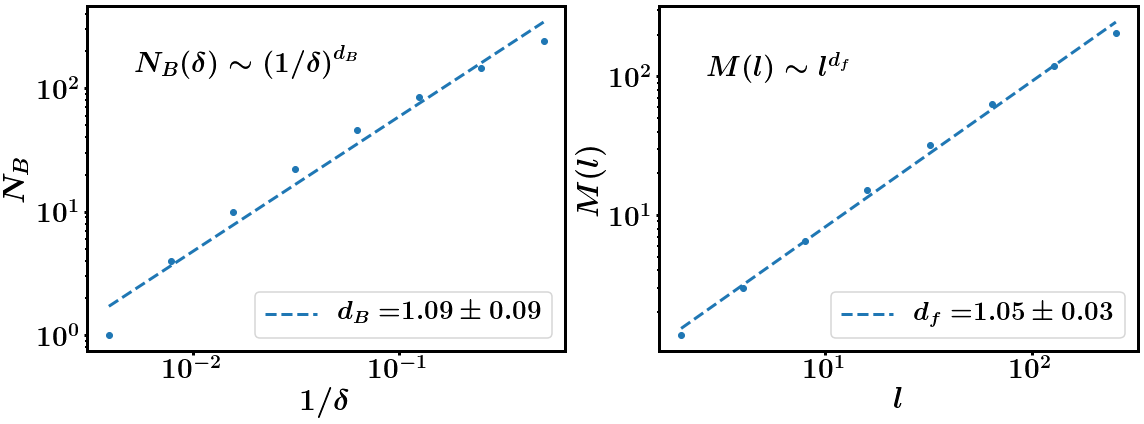

In [109]:
ncols = 2
nrows = 1
fig, axes = plt.subplots(figsize=(8*ncols,6*nrows), ncols=ncols, nrows=nrows)
ax = axes[0]
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$1/\delta$')
ax.set_ylabel(r'$N_B$')
#ax.text(0.1, 0.8, r'$N_B(\delta) \sim \delta^{-d_B}$', transform=ax.transAxes, fontsize=28)
ax.text(
    0.1, 0.8, r'$N_B(\delta) \sim \left(1/\delta\right)^{d_B}$', 
    transform=ax.transAxes, fontsize=28
)
for i, network in enumerate(networks):
    
    box_count_values, l_values = box_count_dict[network]
    X = 1/np.array(l_values)
    box_count_values = box_count_values
    Y_pred, slope, y_err = getLinearReg(X, box_count_values)
    
    ax.plot(X, box_count_values, 'o', color=colors[i])#, label=network)
    label = r'$d_B = $' + r'${{{:.2f}}}\pm{{{:.2f}}}$'.format(slope, y_err)
    ax.plot(X, Y_pred, '--', color=colors[i], label=label)

ax.legend(loc='lower right')


ax = axes[1]
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$l$')
#ax.set_ylabel(r'$M(l) / l^2$')
ax.set_ylabel(r'$M(l)$')
#ax.text(0.6, 0.9, r'$M(l) / l^2 \sim l^{d_f-d}$', transform=ax.transAxes, fontsize=28)
ax.text(0.1, 0.8, r'$M(l) \sim l^{d_f}$', transform=ax.transAxes, fontsize=28)
for i, network in enumerate(networks):
    
    rho_values, l_values = rho_values_dict[network]
    X = l_values
    Y = [rho*l**2 for (rho, l) in zip(rho_values, l_values)]
    Y_pred, slope, y_err = getLinearReg(X, Y)
    
    ax.plot(X, Y, 'o', color=colors[i])#, label=network)
    label = r'$d_f = $' + r'${{{:.2f}}}\pm{{{:.2f}}}$'.format(slope, y_err)
    ax.plot(X, Y_pred, '--', color=colors[i], label=label)

ax.legend(loc='lower right')

plt.tight_layout()
if connected:
    fig_name = os.path.join(fig_dir, 'df_L{}_{}_conn'.format(L, attack))
else:
    fig_name = os.path.join(fig_dir, 'df_L{}_{}'.format(L, attack))
plt.savefig(fig_name + '.png')
plt.savefig(fig_name + '.pdf')

plt.show()

In [54]:
network = 'DT'
attack = 'BtwU'
L = 256
N = L*L
seed = 90

g, max_pos, delta_max = load_delta_data(network, N, param, attack, seed)
position = g.vs['position']
attack_order = g['attack_order']

h = g.copy()
h.delete_vertices(attack_order[max_pos+1:])
gcc = h.components(mode='WEAK').giant()

backbone_indices = gcc.vs['oi']

g.delete_vertices(backbone_indices)
#g.delete_vertices(attack_order[:max_pos+1])
gcc = g.components(mode='WEAK').giant()

Ngcc = gcc.vcount()
print(N, Ngcc, Ngcc/N)
gcc.summary()


65536 37733 0.5757598876953125


'IGRAPH U--- 37733 112599 -- \n+ attr: attack_order (g), oi (v), position (v)'

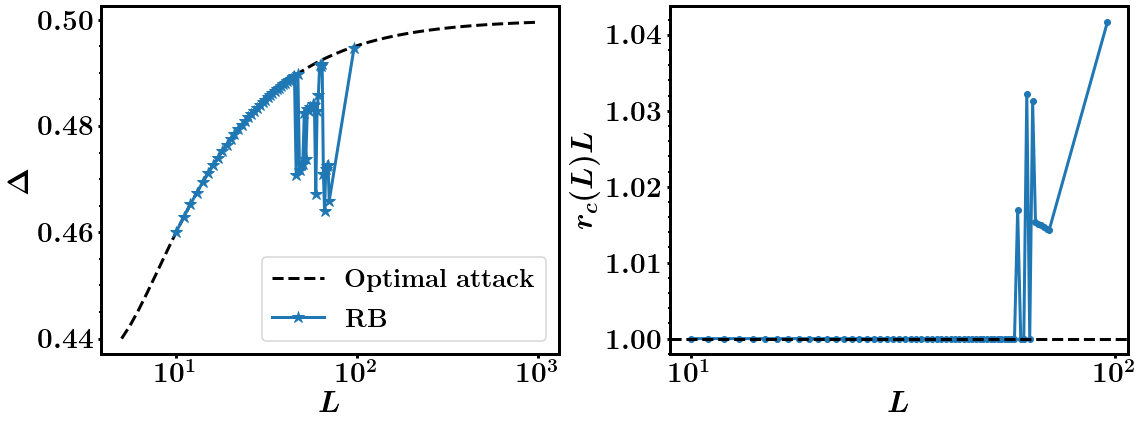

In [62]:
def delta_lattice(L, d=2):
    return 1/2 - 1/(2*L) + 1/L**d

def delta_lattice2(L, d=2):
    return 1/2 - 1/(2*L) - np.sqrt(2)/L + 1/L**d

def delta_DT(L, alpha=0):
    return ((L**2 - alpha*L)/2 + 1) / (L*L)

def fc_optim(L):
    return

def get_dim(network):
    if network == 'Lattice':
        return 2
    if network == 'Ld3':
        return 3

network = 'Lattice'


L_values = np.array(list(range(10, 71)) + [96])
fcN_values = []
norm_mean_delta_values_lattice = []
for L in L_values:
    norm_mean_delta = load_delta(network, L, param, attack, 1)[1]
    fcN = load_delta(network, L, param, attack, 1)[0] + 1/(L*L)
    norm_mean_delta_values_lattice.append(norm_mean_delta)
    fcN_values.append(fcN)

fcN_values = np.array(fcN_values)

linestyles = ['--', '-.']
X = np.logspace(np.log10(5), 3)
ncols = 2
nrows = 1
fig, axes = plt.subplots(figsize=(8*ncols, 6*nrows), ncols=ncols, nrows=nrows)

dim = get_dim(network)

ax = axes[0]

ax.set_xlabel(r'$L$')
ax.set_ylabel(r'$\Delta$')
ax.set_xscale('log')
#ax.set_yscale('log')
ax.plot(
    X**(dim-1), delta_lattice(X, d=dim), linestyles[0], color='k', 
    label=r'$\mathrm{Optimal\;attack}$'
)
ax.plot(L_values**(dim-1), norm_mean_delta_values_lattice, '*-', 
        markersize=12, label=attack_dict[attack])
ax.legend()

ax = axes[1]
ax.set_xscale('log')
ax.set_xlabel(r'$L$')
ax.set_ylabel(r'$r_c(L) L$')
ax.plot(L_values**(dim-1), fcN_values*L_values, 'o-')
ax.axhline(1, linestyle='--', label=r'$\mathrm{Optimal\;attack}$', color='k')

plt.tight_layout()

fig_name = os.path.join(fig_dir, 'Delta_and_fcL_Lattice')
plt.savefig(fig_name + '.png')
plt.savefig(fig_name + '.pdf')
plt.show()

512
1024


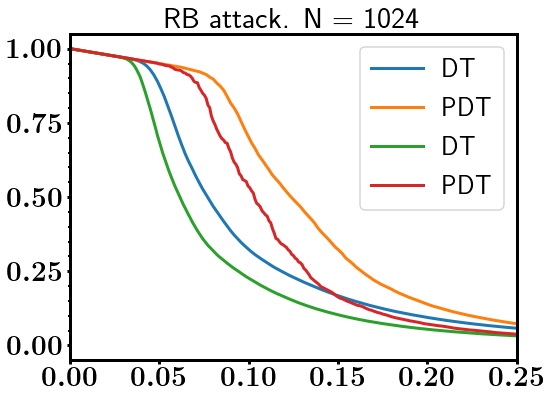

In [61]:
param = 'param'
attack = 'BtwU'

sizes = [512, 1024]
networks = ['DT', 'PDT']
dfs = {net_type: {} for net_type in networks}

for size in sizes:
    for net_type in networks:
        df = load_dataframe(net_type, size, param, attack)
        dfs[net_type][size] = df
        
size = sizes[-1]
        
fig, ax = plt.subplots(figsize=(8, 6))

ax.set_title('RB attack. N = {}'.format(size), fontsize=30)
ax.set_xlim(0, 0.25)
for size in sizes:
    print(size)
    for net_type in networks:
        df = dfs[net_type][size]
        ax.plot(df.f, df.Sgcc, label=net_type)

ax.legend(loc='best')
plt.show()

In [37]:
file_names = ['BtwU_nSeeds1000_cpp.csv', 'BtwU_nSeeds100_cpp.csv']
idx = np.argmax([int(file.split('nSeeds')[1].split('_')[0]) for file in file_names])
file_names[idx]

'BtwU_nSeeds1000_cpp.csv'

1024
2048
4096
8192


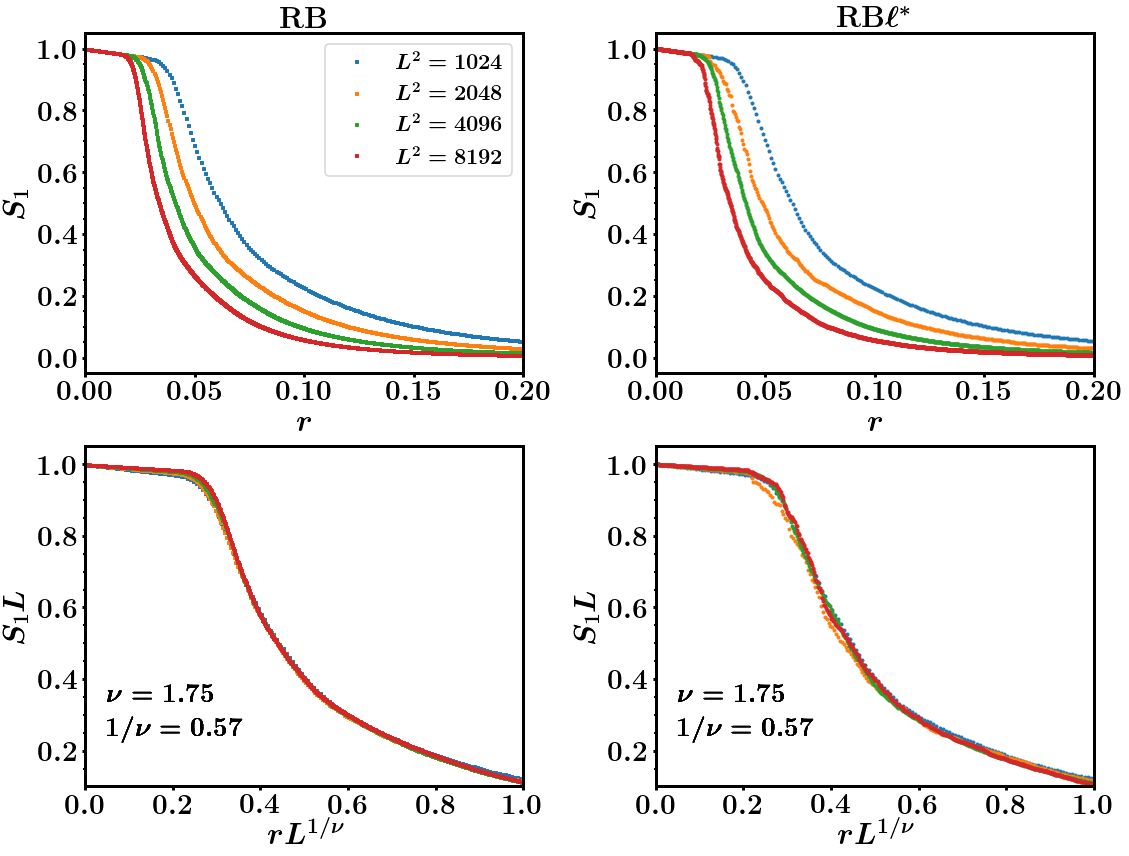

In [149]:
ncols = 2
nrows = 2
fig, axes = plt.subplots(figsize=(8*ncols, 6*nrows), ncols=ncols, nrows=nrows)

for i in range(2):
    ax = axes[0,i]
    ax.set_xlim(0, 0.2)
    ax.set_xlabel(r'$r$')
    ax.set_ylabel(r'$S_1$')
for i in range(2):
    ax = axes[1,i]
    ax.set_xlim(0, 1)
    ax.set_ylim(0.1, 1.05)
    ax.set_ylabel(r'$S_1 L$')
    ax.set_xlabel(r'$r L^{1/\nu}$')
    
axes[0,0].set_title(r'$\mathrm{RB}$', fontsize=30)
axes[0,1].set_title(r'$\mathrm{RB}\ell^*$', fontsize=30)
    
for N in [1024, 2048, 4096, 8192]:
    print(N)
    L = np.sqrt(N)
    l = l_cutoff = get_l_cutoff(0.02)[N]
    for i, attack in enumerate(['BtwU', 'BtwU_cutoff{}'.format(l)]):

        df = load_dataframe(net_type, N, param, attack)
        ax = axes[0,i]
        ax.plot(df.f, df.Sgcc, linestyle='', marker=markers[i], markersize=3,
                label=r'$L^2 = {{{}}}$'.format(N))#, color='k')
        ax = axes[1,i]
        #one_over_nu = 5/9
        one_over_nu = 0.57
        nu = 1 / one_over_nu
        ax.plot(df.f*L**one_over_nu, df.Sgcc, linestyle='', marker=markers[i], markersize=3,
            label=r'${{{}}}$'.format(N))#, color='k')
        ax.text(0.05, 0.25, r'$\nu = {{{:.2f}}}$'.format(nu), 
                transform=ax.transAxes, fontsize=26)
        ax.text(0.05, 0.15, r'$1/\nu = {{{:.2f}}}$'.format(one_over_nu), 
                transform=ax.transAxes, fontsize=26)

axes[0,0].legend(fontsize=22)
plt.tight_layout()
fig_name = os.path.join(fig_dir, 'Sgcc_scaling_RB_{}'.format(net_type))
plt.savefig(fig_name + '.png')
plt.savefig(fig_name + '.pdf')
plt.show()

1024
4096
8192


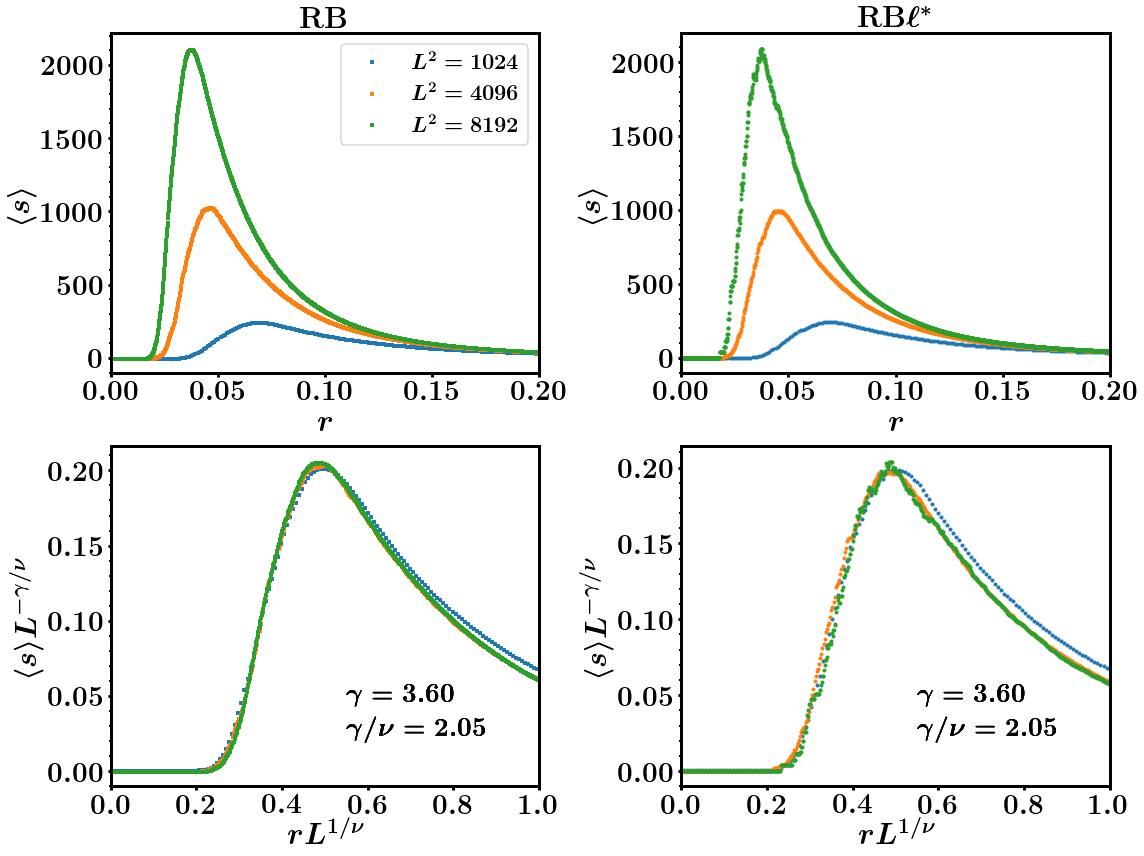

In [150]:
ncols = 2
nrows = 2
fig, axes = plt.subplots(figsize=(8*ncols, 6*nrows), ncols=ncols, nrows=nrows)

for i in range(2):
    ax = axes[0,i]
    ax.set_xlim(0, 0.2)
    ax.set_xlabel(r'$r$')
    ax.set_ylabel(r'$\langle s\rangle$')
for i in range(2):
    ax = axes[1,i]
    ax.set_xlim(0, 1)
    #ax.set_ylim(0.1, 1.05)
    ax.set_ylabel(r'$\langle s\rangle L^{-\gamma/\nu}$')
    ax.set_xlabel(r'$r L^{1/\nu}$')
    
axes[0,0].set_title(r'$\mathrm{RB}$', fontsize=30)
axes[0,1].set_title(r'$\mathrm{RB}\ell^*$', fontsize=30)
    
for N in [1024, 4096, 8192]:
    print(N)
    L = np.sqrt(N)
    l = l_cutoff = get_l_cutoff(0.02)[N]
    for i, attack in enumerate(['BtwU', 'BtwU_cutoff{}'.format(l)]):

        df = load_dataframe(net_type, N, param, attack)
        ax = axes[0,i]
        ax.plot(df.f, df.meanS, linestyle='', marker=markers[i], markersize=3,
                label=r'$L^2 = {{{}}}$'.format(N))#, color='k')
        ax = axes[1,i]
        #one_over_nu = 5/9
        one_over_nu = 0.57
        nu = 1 / one_over_nu
        gamma_over_nu = 2.05
        gamma = gamma_over_nu * nu
        ax.plot(
            df.f*L**one_over_nu, df.meanS*L**(-gamma_over_nu), linestyle='', 
            marker=markers[i], markersize=3,
            label=r'${{{}}}$'.format(N)
        )#, color='k')
        ax.text(0.55, 0.25, r'$\gamma = {{{:.2f}}}$'.format(gamma), 
                transform=ax.transAxes, fontsize=26)
        ax.text(0.55, 0.15, r'$\gamma/\nu = {{{:.2f}}}$'.format(gamma_over_nu), 
                transform=ax.transAxes, fontsize=26)

axes[0,0].legend(fontsize=22)
plt.tight_layout()
fig_name = os.path.join(fig_dir, 'meanS_scaling_RB_{}'.format(net_type))
plt.savefig(fig_name + '.png')
plt.savefig(fig_name + '.pdf')
plt.show()

In [148]:
get_l_cutoff(0.02)

{512: 19, 1024: 24, 2048: 32, 4096: 40, 8192: 54, 16384: 72}